# Цель лабораторной работы
Изучить ансамбли моделей машинного обучения<cite data-cite="ue:lab6"></cite>.

# Задание
Требуется выполнить следующие действия<cite data-cite="ue:lab6"></cite>:

1. Выбрать набор данных (датасет) для решения задачи классификации или регресии.
2. В случае необходимости провести удаление или заполнение пропусков и кодирование категориальных признаков.
3. С использованием метода `train_test_split` разделить выборку на обучающую и тестовую.
4. Обучить две ансамблевые модели. Оценить качество моделей с помощью одной из подходящих для задачи метрик. Сравнить качество полученных моделей.
5. Произвести для каждой модели подбор значений одного гиперпараметра. В зависимости от используемой библиотеки можно применять функцию `GridSearchCV`, использовать перебор параметров в цикле, или использовать другие методы.
6. Повторить пункт 4 для найденных оптимальных значений гиперпараметров. Сравнить качество полученных моделей с качеством моделей, полученных в пункте 4.

# Ход выполнения работы

Подключим все необходимые библиотеки и настроим отображение графиков<cite data-cite="doc:ipython,doc:seaborn"></cite>:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

# Enable inline plots
%matplotlib inline

# Set plots formats to save high resolution PNG
from IPython.display import set_matplotlib_formats
set_matplotlib_formats("retina")

Зададим ширину текстового представления данных, чтобы в дальнейшем текст в отчёте влезал на А4<cite data-cite="doc:pandas"></cite>:

In [2]:
pd.set_option("display.width", 70)

## Предварительная подготовка данных

В качестве набора данных будем использовать датасет с ценами поддержанных машин в Индии<cite data-cite="kg:ucpi"></cite>:

In [3]:
data = pd.read_csv("./used_cars.csv")

Посмотрим на типы данных:

In [4]:
data.dtypes

Index                  int64
Name                  object
Location              object
Year                   int64
Kilometers_Driven      int64
Fuel_Type             object
Transmission          object
Owner_Type            object
Mileage              float64
Engine               float64
Power                float64
Seats                float64
New_Price             object
Price                float64
dtype: object

Посмотрим на данные:

In [5]:
data.head(10)

,Index,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
0,0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.60,998.0,58.16,5.0,NaN,1.75
1,1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67,1582.0,126.20,5.0,NaN,12.50
2,2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.20,1199.0,88.70,5.0,8.61,4.50
3,3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77,1248.0,88.76,7.0,NaN,6.00
4,4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.20,1968.0,140.80,5.0,NaN,17.74
5,5,Hyundai EON LPG Era Plus Option,Hyderabad,2012,75000,LPG,Manual,First,21.10,814.0,55.20,5.0,NaN,2.35
6,6,Nissan Micra Diesel XV,Jaipur,2013,86999,Diesel,Manual,First,23.08,1461.0,63.10,5.0,NaN,3.50
7,7,Toyota Innova Crysta 2.8 GX AT 8S,Mumbai,2016,36000,Diesel,Automatic,First,11.36,2755.0,171.50,8.0,21,17.50
8,8,Volkswagen Vento Diesel Comfortline,Pune,2013,64430,Diesel,Manual,First,20.54,1598.0,103.60,5.0,NaN,5.20
9,9,Tata Indica Vista Quadrajet LS,Chennai,2012,65932,Diesel,Manual,Second,22.30,1248.0,74.00,5.0,NaN,1.95


Удалим ненужные столбцы:

In [6]:
data = data.drop(["Index", "Name", "Location", "New_Price"], axis=1)

Выполним кодирование категориальных признаков:

In [7]:
le = LabelEncoder()
data[["Fuel_Type"]] = le.fit_transform(
    data[["Fuel_Type"]].values.ravel())

data[["Transmission"]] = le.fit_transform(
    data[["Transmission"]].values.ravel())

data[["Owner_Type"]] = le.fit_transform(
    data[["Owner_Type"]].values.ravel())

Проверим данные на наличие пропусков:

In [8]:
data.isnull().sum()

Year                   0
Kilometers_Driven      0
Fuel_Type              0
Transmission           0
Owner_Type             0
Mileage                2
Engine                36
Power                143
Seats                 42
Price                  0
dtype: int64

Заполним пропуски медианным значением:

In [9]:
median_imp = SimpleImputer(strategy="median") 
data[["Mileage"]] =  median_imp.fit_transform(data[["Mileage"]])
data[["Engine"]] = median_imp.fit_transform(data[["Engine"]])
data[["Power"]] = median_imp.fit_transform(data[["Power"]])
data[["Seats"]] = median_imp.fit_transform(data[["Seats"]])

In [10]:
data.isnull().sum()

Year                 0
Kilometers_Driven    0
Fuel_Type            0
Transmission         0
Owner_Type           0
Mileage              0
Engine               0
Power                0
Seats                0
Price                0
dtype: int64

Посмотрим на новые типы данных:

In [11]:
data.dtypes

Year                   int64
Kilometers_Driven      int64
Fuel_Type              int32
Transmission           int32
Owner_Type             int32
Mileage              float64
Engine               float64
Power                float64
Seats                float64
Price                float64
dtype: object

In [12]:
data.head(10)

,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price
0,2010,72000,0,1,0,26.60,998.0,58.16,5.0,1.75
1,2015,41000,1,1,0,19.67,1582.0,126.20,5.0,12.50
2,2011,46000,4,1,0,18.20,1199.0,88.70,5.0,4.50
3,2012,87000,1,1,0,20.77,1248.0,88.76,7.0,6.00
4,2013,40670,1,0,2,15.20,1968.0,140.80,5.0,17.74
5,2012,75000,3,1,0,21.10,814.0,55.20,5.0,2.35
6,2013,86999,1,1,0,23.08,1461.0,63.10,5.0,3.50
7,2016,36000,1,0,0,11.36,2755.0,171.50,8.0,17.50
8,2013,64430,1,1,0,20.54,1598.0,103.60,5.0,5.20
9,2012,65932,1,1,2,22.30,1248.0,74.00,5.0,1.95


Посмотрим на размер данных:

In [13]:
data.shape

(6019, 10)

Посмотрим на основные статистические характеристики набора данных:

In [14]:
data.describe()

,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price
count,6019.000000,6.019000e+03,6019.000000,6019.000000,6019.000000,6019.000000,6019.000000,6019.000000,6019.000000,6019.000000
mean,2013.358199,5.873838e+04,2.363017,0.714238,0.379465,18.134966,1620.509221,112.883539,5.276790,9.479468
std,3.269742,9.126884e+04,1.504939,0.451814,0.818458,4.581528,599.635458,53.283701,0.806346,11.187917
min,1998.000000,1.710000e+02,0.000000,0.000000,0.000000,0.000000,72.000000,34.200000,0.000000,0.440000
25%,2011.000000,3.400000e+04,1.000000,0.000000,0.000000,15.170000,1198.000000,78.000000,5.000000,3.500000
50%,2014.000000,5.300000e+04,1.000000,1.000000,0.000000,18.150000,1493.000000,97.700000,5.000000,5.640000
75%,2016.000000,7.300000e+04,4.000000,1.000000,0.000000,21.100000,1969.000000,138.030000,5.000000,9.950000
max,2019.000000,6.500000e+06,4.000000,1.000000,3.000000,33.540000,5998.000000,560.000000,10.000000,160.000000


## Разделение данных
Разделим данные на целевой столбец и признаки:

In [15]:
x = data.drop("Price", axis=1)
y = data["Price"]

In [16]:
x.head()

,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats
0,2010,72000,0,1,0,26.60,998.0,58.16,5.0
1,2015,41000,1,1,0,19.67,1582.0,126.20,5.0
2,2011,46000,4,1,0,18.20,1199.0,88.70,5.0
3,2012,87000,1,1,0,20.77,1248.0,88.76,7.0
4,2013,40670,1,0,2,15.20,1968.0,140.80,5.0


In [17]:
y.head()

0     1.75
1    12.50
2     4.50
3     6.00
4    17.74
Name: Price, dtype: float64

Обработаем данные, чтобы модель была более точной:

In [18]:
columns = x.columns
scaler = StandardScaler()
x = scaler.fit_transform(x)

Разделим выборку на обучающую и тестовую<cite data-cite="doc:sklearn"></cite>:

In [19]:
x_train, x_test, y_train, y_test = train_test_split(x, y,
                                                    test_size=0.25,
                                                    random_state=77)

In [20]:
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(4514, 9) (1505, 9) (4514,) (1505,)


## Обучение моделей

Напишем функцию, которая считает метрики построенной модели:

In [21]:
def test_model(model, x_test, y_test):
    print("r2_score:", r2_score(y_test, model.predict(x_test)))
    print("mean_squared_error:",
          mean_squared_error(y_test, model.predict(x_test)))
    print("median_absolute_error:",
          median_absolute_error(y_test, model.predict(x_test)))

### Случайный лес

Попробуем случайный лес с гиперпараметром $n=10$:

In [22]:
rfr = RandomForestRegressor(n_estimators=10)
rfr.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [23]:
test_model(rfr, x_test, y_test)

r2_score: 0.8890460199118272
mean_squared_error: 13.708494132387413
median_absolute_error: 0.7109999999999999


Как мы видим, данный метод с заданным гиперпараметром очень хорошо справился с поставленной задачей

### Градиентный бустинг

Попробуем градиентный бустинг с гиперпараметром $n=10$:

In [24]:
gbr = GradientBoostingRegressor(n_estimators=10)
gbr.fit(x_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=10,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [25]:
test_model(gbr, x_test, y_test)

r2_score: 0.6871178032460044
mean_squared_error: 38.65696169639108
median_absolute_error: 2.5185563163435774


Градиентный бустинг с заданным гиперпараметром напротив справиля с задачей довольно плохо

## Подбор гиперпараметра с испльзованием GridSearchCV и кросс-валидациии

### Случайный лес

Создадим список настраиваемых параметров:

In [26]:
param_range = np.arange(1, 101, 1)
grid_params = [{'n_estimators': param_range}]
grid_params

[{'n_estimators': array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
          14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
          27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
          40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
          53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
          66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
          79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
          92,  93,  94,  95,  96,  97,  98,  99, 100])}]

Начнем подбор параметра:

In [27]:
gs = GridSearchCV(RandomForestRegressor(), grid_params,
                  cv=ShuffleSplit(n_splits=5), n_jobs=-1,
                  scoring="r2", return_train_score=True)
gs.fit(x, y)
gs.best_params_

{'n_estimators': 89}

In [28]:
gs.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=89,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

Проверим результаты при разных значения гиперпараметра на тренировочном наборе данных:

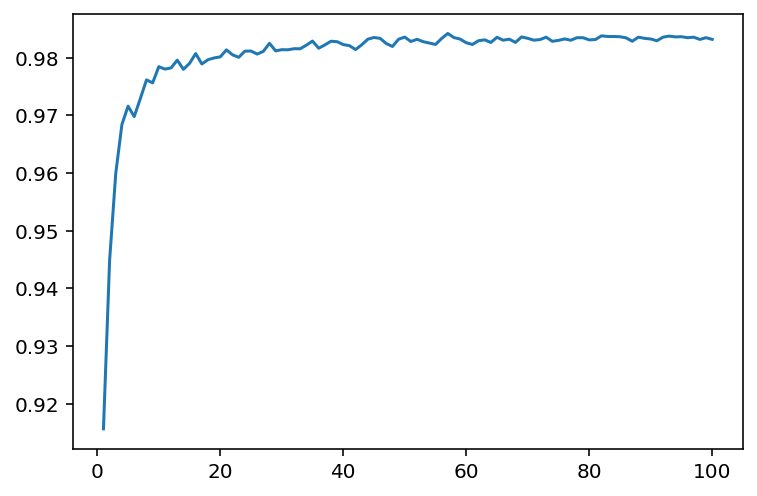

In [29]:
plt.plot(param_range, gs.cv_results_["mean_train_score"]);

На тестовом наборе данных картина похожа:

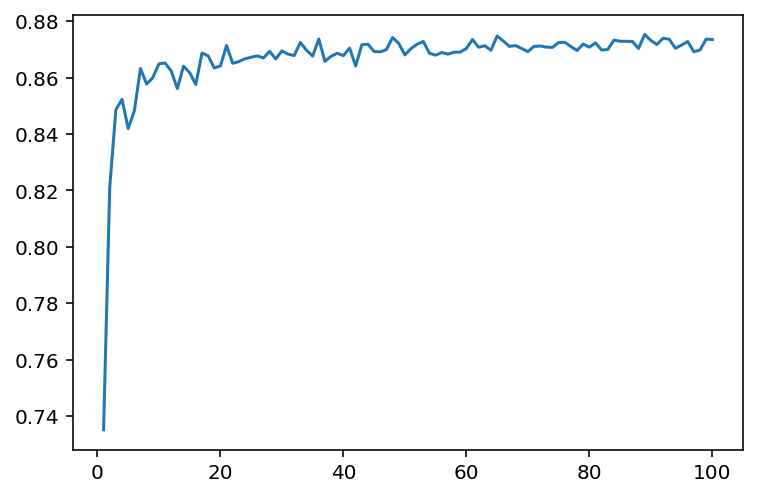

In [30]:
plt.plot(param_range, gs.cv_results_["mean_test_score"]);

Обучим модель с использованием подобранного параметра:

In [31]:
rfr = RandomForestRegressor(n_estimators=gs.best_params_['n_estimators'])
rfr.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=89,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [32]:
test_model(rfr, x_test, y_test)

r2_score: 0.868823578963514
mean_squared_error: 16.207000385720566
median_absolute_error: 0.6920224719101151


Как мы видим, модель дала лишь небольшое улучшение с подобранным параметром

### Градиентный бустинг

Создадим список настраиваемых параметров:

In [33]:
param_range = np.arange(1, 101, 5)
grid_params = [{'n_estimators': param_range}]
grid_params

[{'n_estimators': array([ 1,  6, 11, 16, 21, 26, 31, 36, 41, 46, 51, 56, 61, 66, 71, 76, 81,
         86, 91, 96])}]

Начнем подбор параметра:

In [34]:
gs = GridSearchCV(GradientBoostingRegressor(), grid_params,
                  cv=ShuffleSplit(n_splits=5), n_jobs=-1,
                  scoring="r2", return_train_score=True)
gs.fit(x, y)
gs.best_params_

{'n_estimators': 96}

In [35]:
gs.best_estimator_

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=96,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

Проверим результаты при разных значения гиперпараметра на тренировочном наборе данных:

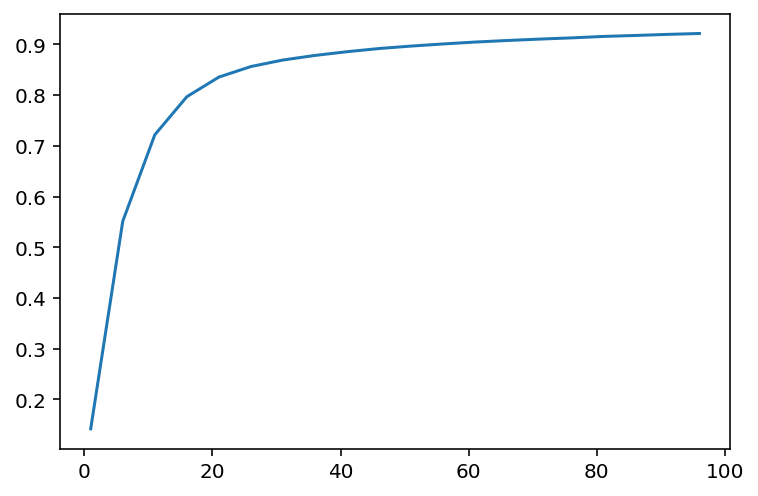

In [36]:
plt.plot(param_range, gs.cv_results_["mean_train_score"]);

На тестовом наборе данных картина абсолютно аналогичная:

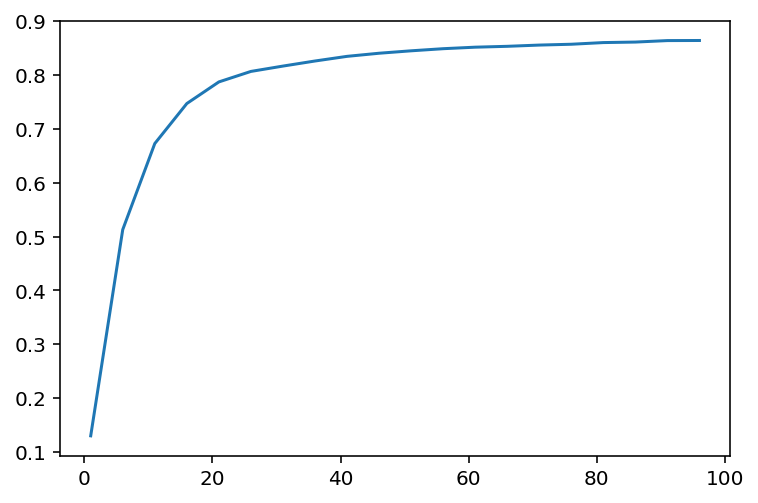

In [37]:
plt.plot(param_range, gs.cv_results_["mean_test_score"]);

Обучим модель с использованием подобранного параметра:

In [38]:
gbr = GradientBoostingRegressor(n_estimators=gs.best_params_['n_estimators'])
gbr.fit(x_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=96,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [39]:
test_model(gbr, x_test, y_test)

r2_score: 0.876435064672588
mean_squared_error: 15.266592415689454
median_absolute_error: 0.8966593689525348


В данном случае модель дала заметное улучшение с подобранным параметром